# Necessary imports

In [4]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Main classes

### Data loader

In [10]:
class MigrationData:
    
    """
    Loads and validates the migration CSV dataset.

    Required columns:
    - country_from
    - country_to
    - migration_month
    - num_migrants
    """

    def __init__(self, filepath):
        self.filepath = filepath
        self.required_columns = [
            'country_from',
            'country_to',
            'migration_month',
            'num_migrants'
        ]

    def load_data(self):
        try:
            # Tell pandas NOT to convert "NA" strings into NaN automatically
            # NA is code for Namibia, which is a valid country name in our dataset
            df = pd.read_csv(self.filepath, keep_default_na=False, na_values=[''])

            missing_cols = [col for col in self.required_columns if col not in df.columns]
            if missing_cols:
                print(f"Error: The dataset is missing the following required columns: {missing_cols}")
                return None

            print("Dataset loaded and validated successfully!")
            return df

        except FileNotFoundError:
            print(f"Error: The file '{self.filepath}' could not be found. Please check the path.")
            return None

        except Exception as e:
            print(f"An unexpected error occurred while loading the data: {e}")
            return None

### Monthly network builder

In [2]:
class TemporalNetwork:

    """
    Builds directed weighted migration networks for each month.
    """

    def __init__(self, dataframe):
        self.df = dataframe

    def build_monthly_networks(self):
        """
        Returns
        -------
        dict
            {month_key: networkx.DiGraph}
        """
        monthly_networks = {}

        grouped_data = self.df.groupby('migration_month')

        for month, group in grouped_data:
            G = nx.DiGraph()

            for _, row in group.iterrows():
                source = row['country_from']
                target = row['country_to']
                weight = row['num_migrants']

                if weight > 0:
                    G.add_edge(source, target, weight=weight)

            monthly_networks[month] = G

        print(f"\nSuccessfully constructed networks for {len(monthly_networks)} months.")
        return monthly_networks

### Centrality analyzer

In [5]:
class CentralityAnalyzer:

    """
    Computes PageRank, Betweenness, and Centralization over time.
    """

    def __init__(self, monthly_networks: dict):
        self.monthly_networks = monthly_networks
        self.months = sorted(list(monthly_networks.keys()))
        self.all_countries = self._get_all_countries()

    def _get_all_countries(self):
        countries = set()
        for G in self.monthly_networks.values():
            for n in G.nodes():
                if isinstance(n, str) and n.strip() != "":
                    countries.add(n)
        return sorted(countries)

    def _to_time_df(self, series_by_month: dict, fill_value=0.0):
        df = pd.DataFrame(index=self.months, columns=self.all_countries, dtype=float)
        for month, node_dict in series_by_month.items():
            for node, val in node_dict.items():
                df.loc[month, node] = val
        return df.fillna(fill_value)

    # PageRank
    def compute_pagerank_over_time(self, weight="weight", alpha=0.85):
        pr_by_month = {}
        for month, G in self.monthly_networks.items():
            if G.number_of_nodes() == 0:
                pr_by_month[month] = {}
            else:
                pr_by_month[month] = nx.pagerank(G, alpha=alpha, weight=weight)
        return self._to_time_df(pr_by_month, fill_value=0.0)

    # Betweenness
    def compute_betweenness_over_time(self, normalized=True):
        bt_by_month = {}
        for month, G in self.monthly_networks.items():
            if G.number_of_nodes() == 0:
                bt_by_month[month] = {}
            else:
                bt_by_month[month] = nx.betweenness_centrality(G, normalized=normalized)
        return self._to_time_df(bt_by_month, fill_value=0.0)

    # Centralization
    def compute_centralization_over_time(self, metric="pagerank", weight="weight", alpha=0.85):
        centralization = {}
        for month, G in self.monthly_networks.items():
            if metric.lower() == "pagerank":
                c = nx.pagerank(G, alpha=alpha, weight=weight)
            elif metric.lower() == "betweenness":
                c = nx.betweenness_centrality(G, normalized=True)
            else:
                raise ValueError("metric must be 'pagerank' or 'betweenness'")

            vals = list(c.values())
            total = sum(vals)
            centralization[month] = (max(vals) / total) if total != 0 else 0.0

        return pd.Series(centralization).sort_index()

    # Top countries
    def top_countries(self, centrality_df: pd.DataFrame, k=10, method="mean"):
        if method == "mean":
            scores = centrality_df.mean(axis=0)
        elif method == "sum":
            scores = centrality_df.sum(axis=0)
        elif method == "last":
            scores = centrality_df.iloc[-1]
        else:
            raise ValueError("method must be 'mean', 'sum', or 'last'")

        return scores.sort_values(ascending=False).head(k).index.tolist()

### Centrality visualization

In [7]:
class visualizer:

    def pagerank_evolution(self, pagerank_df,top_pagerank):
        plt.figure(figsize=(12,6))
        for country in top_pagerank:
            plt.plot(pagerank_df.index, pagerank_df[country], label=country)
        plt.title(f"Evolution of PageRank Over Time")
        plt.xlabel("Month")
        plt.ylabel("PageRank")
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def centralization_evolution(self, centralization_series):
        plt.figure(figsize=(12,6))
        plt.plot(centralization_series.index, centralization_series.values)
        plt.title("Network Centralization Over Time")
        plt.xlabel("Month")
        plt.ylabel("Centralization")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

### Interpretation helper

In [12]:
class NetworkInterpreter:
    """
    Generates statistical insights from centrality metrics to aid in the 
    interpretation of the global migration network.
    """

    def __init__(self, pagerank_df, betweenness_df, centralization_series):
        self.pagerank_df = pagerank_df
        self.betweenness_df = betweenness_df
        self.centralization_series = centralization_series

    def identify_central_hubs(self, top_k=10):
        # Calculate mean and standard deviation (volatility) of PageRank
        pr_mean = self.pagerank_df.mean()
        pr_std = self.pagerank_df.std()
        
        # Combine into a DataFrame and sort by highest average PageRank
        pr_stats = pd.DataFrame({
            'Mean_PageRank': pr_mean, 
            'Volatility_Std': pr_std
        }).sort_values(by='Mean_PageRank', ascending=False)
        
        print(f"\n1. Consistently Central Hubs (Top {top_k}):")
        print(pr_stats.head(top_k))
        print("Look for countries with a high 'Mean_PageRank' and a low 'Volatility_Std' to identify stable hubs.")
        return pr_stats

    def identify_corridors(self, top_k=10):
        # Calculate mean betweenness and sort descending
        bt_mean = self.betweenness_df.mean().sort_values(ascending=False)
        
        print(f"\n2. Corridor Countries (Top {top_k} Mean Betweenness):")
        print(bt_mean.head(top_k))
        print("These countries act as key transit points connecting weakly connected regions.")
        return bt_mean

    def analyze_centralization_trend(self):
        c_mean = self.centralization_series.mean()
        c_min = self.centralization_series.min()
        c_max = self.centralization_series.max()
        
        print("\n3. Network Centralization Summary:")
        print(f"Average Centralization: {c_mean:.4f}")
        print(f"Min Centralization:     {c_min:.4f}")
        print(f"Max Centralization:     {c_max:.4f}")
        
        # Calculate a simple trend from start to finish
        if len(self.centralization_series) > 1:
            start_val = self.centralization_series.iloc[0]
            end_val = self.centralization_series.iloc[-1]
            trend_direction = "increased" if end_val > start_val else "decreased"
            print(f"Trend: Centralization {trend_direction} from {start_val:.4f} to {end_val:.4f}.")
            print("Use this to explain if migration is concentrating around a few countries or spreading out.")

    def generate_full_report(self):
        """Runs all interpretation methods and prints a comprehensive summary."""
        print("\n" + "="*50)
        print("DATA-DRIVEN INSIGHTS FOR INTERPRETATION")
        print("="*50)
        self.identify_central_hubs()
        self.identify_corridors()
        self.analyze_centralization_trend()

# 3. Main execution demonstration

Loading dataset...
Dataset loaded and validated successfully!
Dataset loaded.
Preview:
  country_from country_to migration_month  num_migrants
0           AD         AE         2019-01            12
1           AD         AE         2019-02             2
2           AD         AE         2019-03             1
3           AD         AE         2019-04             7
4           AD         AE         2019-05             0

Building monthly networks...

Successfully constructed networks for 48 months.

Inspection for month: 2019-01
Total Nodes (Countries): 181
Total Edges (Migration Flows): 20037

Analyzing centrality metrics over time...

Persistent Structural Hubs (Top 10 PageRank):
['US', 'IN', 'GB', 'DE', 'SA', 'AE', 'FR', 'PH', 'CA', 'ES']

Corridor Countries (Top 10 Betweenness):
['US', 'IN', 'GB', 'CA', 'FR', 'DE', 'TR', 'IT', 'AE', 'PH']

Generating visualizations...


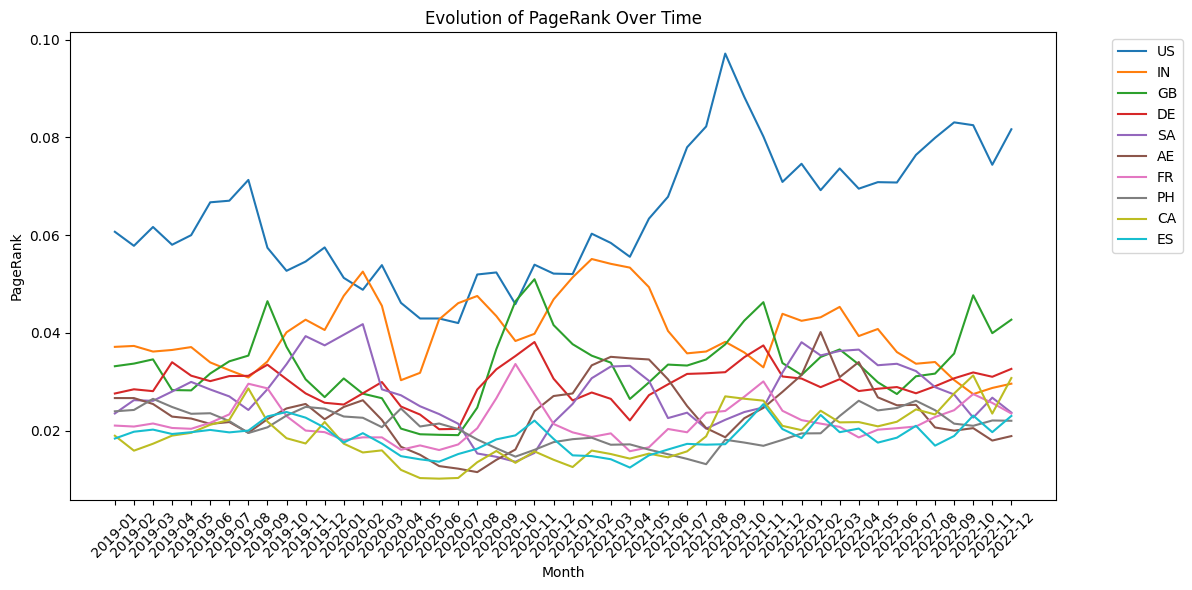

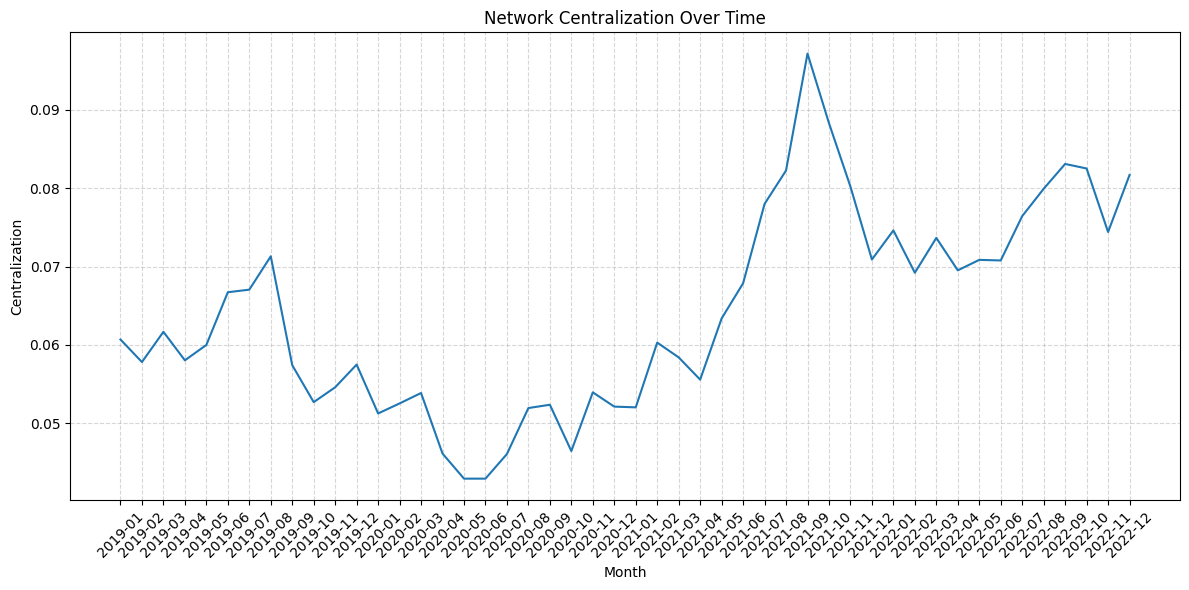



DATA-DRIVEN INSIGHTS FOR INTERPRETATION

1. Consistently Central Hubs (Top 10):
    Mean_PageRank  Volatility_Std
US       0.063974        0.013204
IN       0.039797        0.007140
GB       0.033587        0.007373
DE       0.029453        0.003753
SA       0.027875        0.006714
AE       0.024007        0.006398
FR       0.021862        0.003960
PH       0.020680        0.003513
CA       0.019202        0.005335
ES       0.018768        0.002956
Look for countries with a high 'Mean_PageRank' and a low 'Volatility_Std' to identify stable hubs.

2. Corridor Countries (Top 10 Mean Betweenness):
US    0.006054
IN    0.005050
GB    0.004851
CA    0.004619
FR    0.004477
DE    0.004281
TR    0.003949
IT    0.003910
AE    0.003716
PH    0.003685
dtype: float64
These countries act as key transit points connecting weakly connected regions.

3. Network Centralization Summary:
Average Centralization: 0.0641
Min Centralization:     0.0430
Max Centralization:     0.0971
Trend: Centralization 

In [13]:
def main():
    # 1. Load and validate data
    print("Loading dataset...")
    migration_file = "international_migration_flow.csv"
    loader = MigrationData(migration_file)
    df = loader.load_data()

    # Exit if data fails to load
    if df is None:
        print("Failed to load data. Please check the file path and try again.")
        return

    print("Dataset loaded.\nPreview:")
    print(df.head())

    # 2. Build monthly networks
    print("\nBuilding monthly networks...")
    network_constructor = TemporalNetwork(df)
    monthly_networks_dict = network_constructor.build_monthly_networks()

    sample_month = list(monthly_networks_dict.keys())[0]
    sample_graph = monthly_networks_dict[sample_month]

    print(f"\nInspection for month: {sample_month}")
    print(f"Total Nodes (Countries): {sample_graph.number_of_nodes()}")
    print(f"Total Edges (Migration Flows): {sample_graph.number_of_edges()}")

    # 3. Compute Centrality measures
    print("\nAnalyzing centrality metrics over time...")
    analyzer = CentralityAnalyzer(monthly_networks_dict)

    pagerank_df = analyzer.compute_pagerank_over_time()
    betweenness_df = analyzer.compute_betweenness_over_time()
    centralization_series = analyzer.compute_centralization_over_time(metric="pagerank")

    # 4. Identify structural hubs and corridors
    top_pagerank = analyzer.top_countries(pagerank_df, k=10, method="mean")
    top_betweenness = analyzer.top_countries(betweenness_df, k=10, method="mean")

    print("\nPersistent Structural Hubs (Top 10 PageRank):")
    print(top_pagerank)
    
    print("\nCorridor Countries (Top 10 Betweenness):")
    print(top_betweenness)

    # 5. Generate plots
    print("\nGenerating visualizations...")
    viz = visualizer()
    
    # Plot the evolution of PageRank for the top countries over time
    viz.pagerank_evolution(pagerank_df, top_pagerank)
    
    # Plot the centralization of the migration network over time
    viz.centralization_evolution(centralization_series)

    # Outputting prompts for the required written interpretation
    print("\n" + "="*40)
    # Generate insights for interpretation
    interpreter = NetworkInterpreter(pagerank_df, betweenness_df, centralization_series)
    interpreter.generate_full_report()

if __name__ == "__main__":
    main()

# 4. Extended classes

In [14]:
class ExtendedCentralityAnalyzer(CentralityAnalyzer):
    """
    Extends the CentralityAnalyzer to include volatility, emerging hub detection,
    safe betweenness computation, and net migration analysis.
    """
    
    def compute_betweenness_over_time(self, normalized=True):
        """
        Overrides the original method to handle zero flows and correct weight logic.
        In networkx, betweenness uses weights as 'distance'. Higher flow should mean 
        closer distance. We calculate distance = 1 / weight.
        """
        bt_by_month = {}
        for month, G in self.monthly_networks.items():
            if G.number_of_nodes() == 0:
                bt_by_month[month] = {}
                continue
                
            # Create a distance attribute to handle weights correctly and avoid zero division
            for u, v, data in G.edges(data=True):
                weight = data.get('weight', 0)
                data['distance'] = 1.0 / weight if weight > 0 else float('inf')
                
            bt_by_month[month] = nx.betweenness_centrality(
                G, normalized=normalized, weight='distance'
            )
        return self._to_time_df(bt_by_month, fill_value=0.0)

    def compute_pagerank_volatility(self, pagerank_df):
        """Computes the standard deviation of PageRank to measure stability."""
        return pagerank_df.std(axis=0).sort_values(ascending=False)

    def detect_emerging_hubs(self, pagerank_df, top_k=5):
        """
        Identifies countries with the highest positive growth in PageRank 
        from the beginning to the end of the dataset.
        """
        if len(pagerank_df) < 2:
            return pd.Series(dtype=float)
        
        # Calculate the absolute growth in centrality
        growth = pagerank_df.iloc[-1] - pagerank_df.iloc[0]
        return growth.sort_values(ascending=False).head(top_k)
    
    def compute_net_migration_roles(self):
        """
        Creative addition: Calculates Net Migration (In-Degree Weight - Out-Degree Weight)
        Positive = Net Receiver, Negative = Net Sender
        """
        net_migration_by_month = {}
        for month, G in self.monthly_networks.items():
            net_migration = {}
            for node in G.nodes():
                in_weight = G.in_degree(node, weight='weight')
                out_weight = G.out_degree(node, weight='weight')
                net_migration[node] = in_weight - out_weight
            net_migration_by_month[month] = net_migration
            
        return self._to_time_df(net_migration_by_month, fill_value=0.0)
    
    def detect_role_switches(self, net_migration_df):
        """
        Identifies countries that switched their primary role from Net Sender to Net Receiver 
        (or vice versa) between the start and end of the timeline.
        """
        if len(net_migration_df) < 2:
            print("Not enough time periods to detect role switches.")
            return pd.DataFrame()
            
        first_month = net_migration_df.iloc[0]
        last_month = net_migration_df.iloc[-1]
        
        switches = []
        for country in net_migration_df.columns:
            start_val = first_month[country]
            end_val = last_month[country]
            
            # Check for strict sign flip (ignoring zeros)
            if start_val < 0 and end_val > 0:
                switches.append({
                    'Country': country, 
                    'Switch_Type': 'Sender to Receiver', 
                    'Magnitude': abs(end_val - start_val)
                })
            elif start_val > 0 and end_val < 0:
                switches.append({
                    'Country': country, 
                    'Switch_Type': 'Receiver to Sender', 
                    'Magnitude': abs(end_val - start_val)
                })
                
        # Convert to DataFrame and sort by the magnitude of the switch
        switches_df = pd.DataFrame(switches)
        if not switches_df.empty:
            switches_df = switches_df.sort_values(by='Magnitude', ascending=False).reset_index(drop=True)
            
        return switches_df

In [17]:
class AdvancedVisualizer:
    """Handles repeated plotting operations and advanced graphical interpretation."""
    
    def _apply_standard_styling(self, ax, title, xlabel, ylabel):
        """Helper method to keep charts looking clean and consistent."""
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle='--', alpha=0.6)
        
        # Safely extract labels and create the legend outside the plot
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    def plot_volatility(self, volatility_series, top_k=15):
        """Plots a bar chart of the most volatile migration hubs with a color legend."""
        fig, ax = plt.subplots(figsize=(12, 6))
        top_volatile = volatility_series.head(top_k)
        
        # Plot each country individually to give it a distinct color and legend label
        countries = top_volatile.index
        values = top_volatile.values
        colors = plt.cm.tab20(np.linspace(0, 1, len(countries))) # Generate distinct colors
        
        for country, val, color in zip(countries, values, colors):
            ax.bar(country, val, color=color, label=country)
            
        self._apply_standard_styling(ax, "Top PageRank Volatility (Most Unstable Hubs)", "Country", "Standard Deviation")
        plt.tight_layout()
        plt.show()

    def plot_emerging_hubs(self, pagerank_df, emerging_series):
        """Plots the PageRank evolution specifically for emerging countries."""
        fig, ax = plt.subplots(figsize=(12, 6))
        emerging_countries = emerging_series.index.tolist()
        
        for country in emerging_countries:
            ax.plot(pagerank_df.index, pagerank_df[country], marker='o', 
                    label=f"{country} (+{emerging_series[country]:.4f})")
            
        self._apply_standard_styling(ax, "Emerging Migration Hubs (Highest Growth)", "Month", "PageRank")
        plt.tight_layout()
        plt.show()

    def plot_net_migration_roles(self, net_migration_df, countries):
        """Plots whether selected countries are net senders or receivers over time."""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        for country in countries:
            ax.plot(net_migration_df.index, net_migration_df[country], marker='s', label=country, linewidth=2)
            
        ax.axhline(0, color='black', linestyle='-', linewidth=1.5, label='Net Zero Migration')
        self._apply_standard_styling(ax, "Migration Roles: Net Senders (-) vs Net Receivers (+)", "Month", "Net Migrants (In - Out)")
        plt.tight_layout()
        plt.show()

    def plot_role_switches(self, net_migration_df, switches_df, top_k=3):
        """Plots the net migration timeline for countries that switched roles."""
        if switches_df.empty:
            print("No structural role switches detected to plot.")
            return
            
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Take the top 'k' biggest role switches
        countries_to_plot = switches_df.head(top_k)['Country'].tolist()
        
        for country in countries_to_plot:
            switch_type = switches_df.loc[switches_df['Country'] == country, 'Switch_Type'].values[0]
            ax.plot(net_migration_df.index, net_migration_df[country], marker='^', 
                    label=f"{country} ({switch_type})")
            
        # Draw a thick line at 0 to clearly show the "switch" boundary
        ax.axhline(0, color='red', linestyle='--', linewidth=2, label='Role Switch Boundary (Zero Net)')
        
        self._apply_standard_styling(ax, "Structural Role Switches Over Time", "Month", "Net Migrants (In - Out)")
        plt.tight_layout()
        plt.show()

STARTING EXTENDED ANALYSIS (TASK 6)
Loading data and building networks for extended analysis...
Dataset loaded and validated successfully!

Successfully constructed networks for 48 months.

Initializing Extended Centrality Analyzer...
-> Computing PageRank and safely handling zero-flow Betweenness...
-> Computing PageRank Volatility...
-> Detecting Emerging Hubs...
-> Calculating Net Migration Roles...
-> Detecting Structural Role Switches...

------------------------------
EXTENDED METRICS SUMMARY
------------------------------
Top 5 Most Volatile Countries (Highest Std Dev):
US    0.013204
GB    0.007373
IN    0.007140
AU    0.006858
SA    0.006714
dtype: float64

Top 5 Emerging Hubs (Absolute PageRank Growth):
US    0.020968
CA    0.011804
GB    0.009521
AU    0.009231
MX    0.008811
dtype: float64

Detected Role Switches (Top by Magnitude):
  Country         Switch_Type  Magnitude
0      SA  Sender to Receiver   208376.0
1      CO  Receiver to Sender   144535.0
2      PK  Receiver 

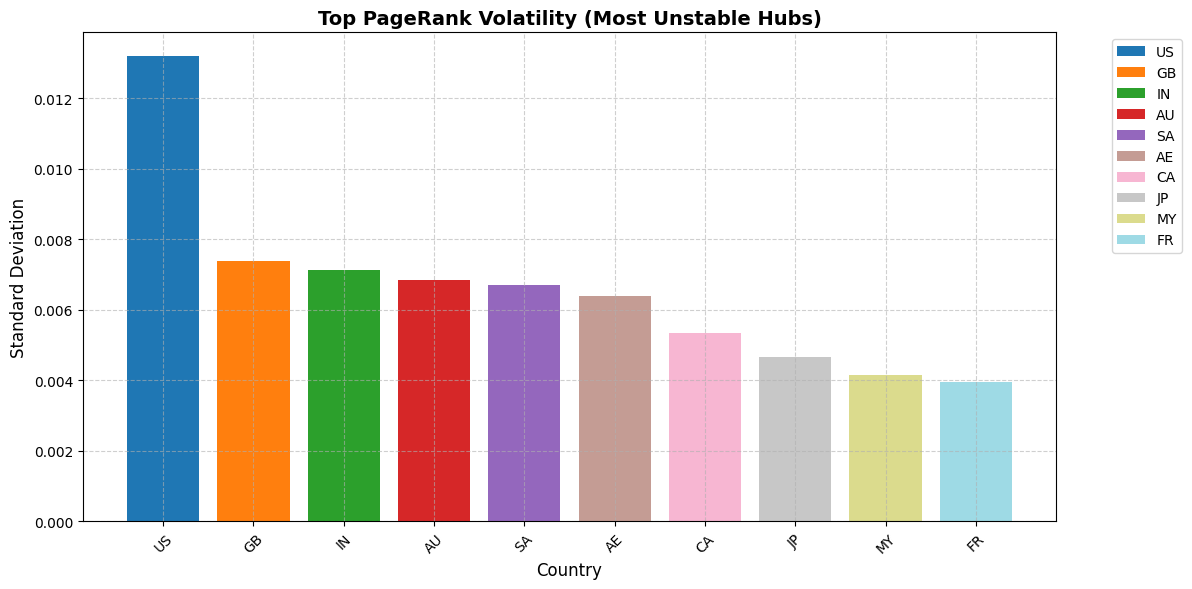

Plotting Emerging Hubs Evolution...


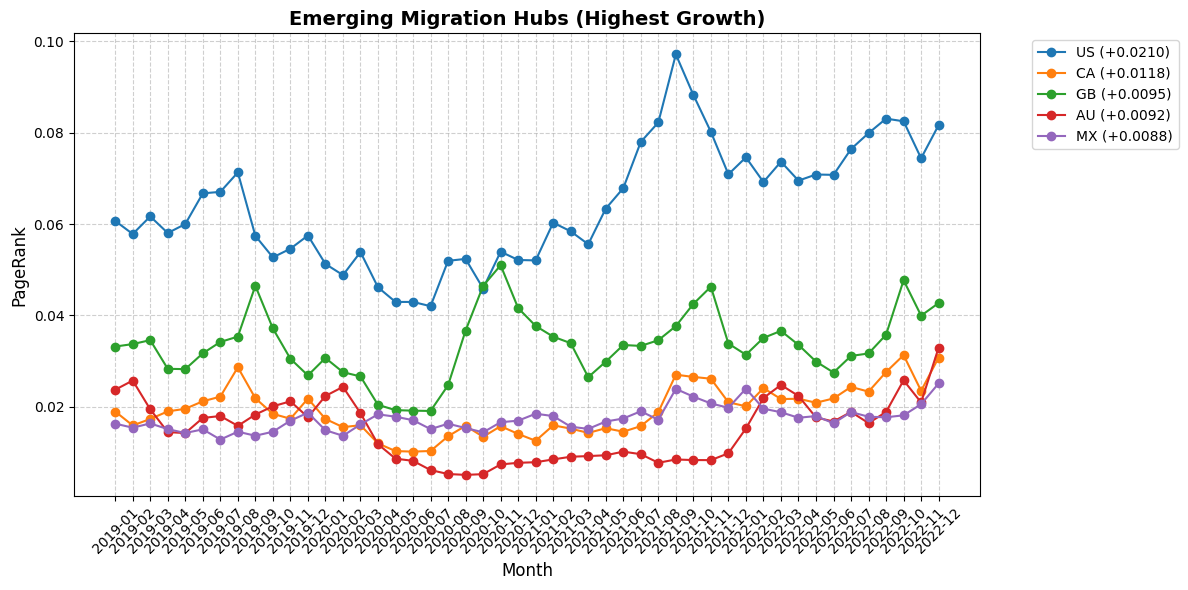

Plotting Net Migration Context for Top Emerging Hubs...


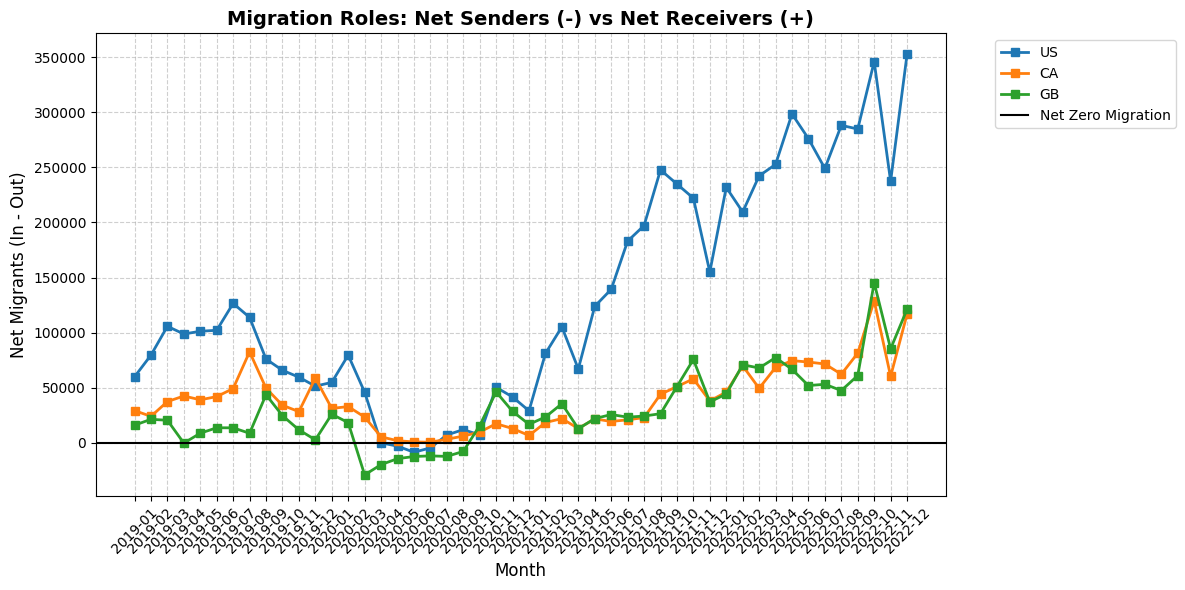

Plotting Structural Role Switches...


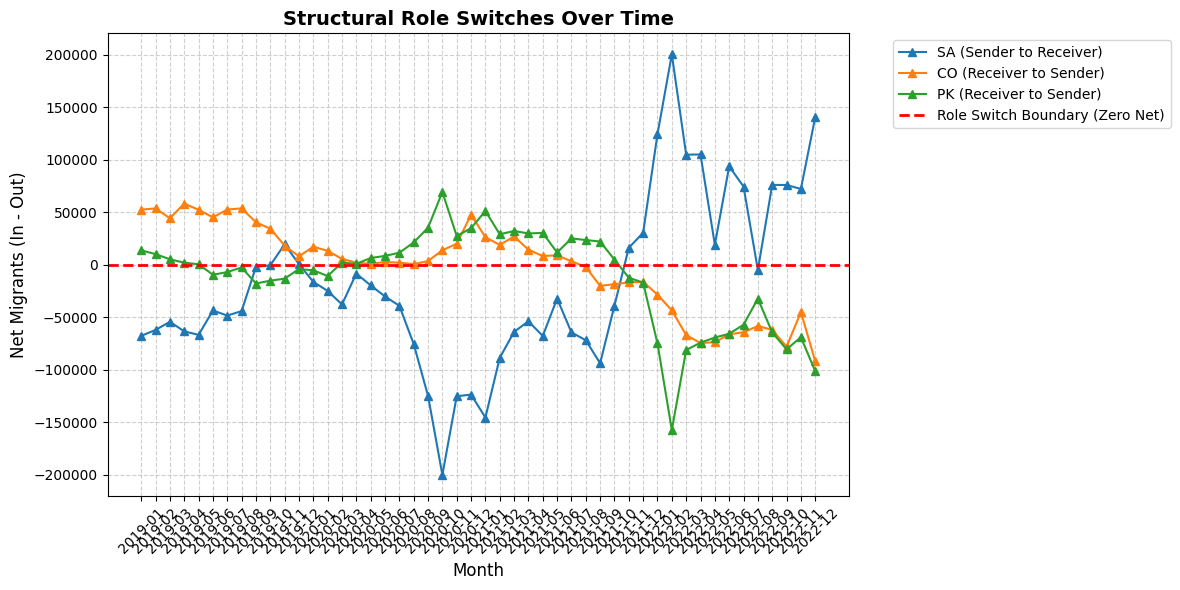


--- Extended Analysis Complete ---


In [18]:
def run_extended_analysis():
    print("="*50)
    print("STARTING EXTENDED ANALYSIS (TASK 6)")
    print("="*50)

    # 1. Prerequisite Setup: Load Data and Build Networks
    print("Loading data and building networks for extended analysis...")
    loader = MigrationData("international_migration_flow.csv")
    df = loader.load_data()
    
    if df is None:
        print("Failed to load data. Please check the file path.")
        return
        
    network_constructor = TemporalNetwork(df)
    monthly_networks_dict = network_constructor.build_monthly_networks()

    # 2. Instantiate the Extended Analyzer
    print("\nInitializing Extended Centrality Analyzer...")
    ext_analyzer = ExtendedCentralityAnalyzer(monthly_networks_dict)

    # 3. Compute Metrics
    print("-> Computing PageRank and safely handling zero-flow Betweenness...")
    pagerank_df = ext_analyzer.compute_pagerank_over_time()
    betweenness_df = ext_analyzer.compute_betweenness_over_time() 
    
    print("-> Computing PageRank Volatility...")
    volatility_series = ext_analyzer.compute_pagerank_volatility(pagerank_df)
    
    print("-> Detecting Emerging Hubs...")
    emerging_hubs_series = ext_analyzer.detect_emerging_hubs(pagerank_df, top_k=5)
    
    print("-> Calculating Net Migration Roles...")
    net_migration_df = ext_analyzer.compute_net_migration_roles()
    
    print("-> Detecting Structural Role Switches...")
    switches_df = ext_analyzer.detect_role_switches(net_migration_df)

    # Print Text Summaries
    print("\n" + "-"*30)
    print("EXTENDED METRICS SUMMARY")
    print("-"*30)
    print("Top 5 Most Volatile Countries (Highest Std Dev):")
    print(volatility_series.head(5))
    
    print("\nTop 5 Emerging Hubs (Absolute PageRank Growth):")
    print(emerging_hubs_series)
    
    if not switches_df.empty:
        print("\nDetected Role Switches (Top by Magnitude):")
        print(switches_df.head(5))
    else:
        print("\nNo structural role switches detected in this timeframe.")

    # 4. Generate Advanced Visualizations
    print("\n" + "="*50)
    print("GENERATING ADVANCED VISUALIZATIONS")
    print("="*50)
    adv_viz = AdvancedVisualizer()
    
    # Plot 1: Volatility
    print("Plotting Network Volatility...")
    adv_viz.plot_volatility(volatility_series, top_k=10)
    
    if not emerging_hubs_series.empty:
        # Plot 2: Emerging Hubs PageRank Growth
        print("Plotting Emerging Hubs Evolution...")
        adv_viz.plot_emerging_hubs(pagerank_df, emerging_hubs_series)
        
        # Plot 3: Net Migration context for the top 3 emerging hubs
        print("Plotting Net Migration Context for Top Emerging Hubs...")
        top_emerging_list = emerging_hubs_series.index.tolist()[:3]
        adv_viz.plot_net_migration_roles(net_migration_df, top_emerging_list)
    
    if not switches_df.empty:
        # Plot 4: Structural Role Switches
        print("Plotting Structural Role Switches...")
        adv_viz.plot_role_switches(net_migration_df, switches_df, top_k=3)

    print("\n--- Extended Analysis Complete ---")

# Execute the extended analysis
if __name__ == "__main__":
    run_extended_analysis()